## Predicting cardio vascular disease using machine learning
#### Given clinical parameters about a patient, predict whether or not they have cardio vascular disease.
##### Features:
1.	Age | Objective Feature | age | int (days)
2.	Height | Objective Feature | height | int (cm) |
3.	Weight | Objective Feature | weight | float (kg) |
4.	Gender | Objective Feature | gender | categorical code |
5.	Systolic blood pressure | Examination Feature | ap_hi | int |
6.	Diastolic blood pressure | Examination Feature | ap_lo | int |
7.	Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
8.	Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
9.	Smoking | Subjective Feature | smoke | binary |
10.	Alcohol intake | Subjective Feature | alco | binary |
11.	Physical activity | Subjective Feature | active | binary |
12.	Presence or absence of cardiovascular disease | Target Variable | cardio | binary |



In [1]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [2]:
# Load data
df = pd.read_csv("cardio_train.csv",sep=";")
df.head()
# Here we can see that age is in days.

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,989,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,990,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,991,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,992,23393,1,155,62.0,120,80,1,1,0,0,1,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69301 entries, 0 to 69300
Data columns (total 13 columns):
id             69301 non-null int64
age            69301 non-null int64
gender         69301 non-null int64
height         69301 non-null int64
weight         69301 non-null float64
ap_hi          69301 non-null int64
ap_lo          69301 non-null int64
cholesterol    69301 non-null int64
gluc           69301 non-null int64
smoke          69301 non-null int64
alco           69301 non-null int64
active         69301 non-null int64
cardio         69301 non-null int64
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


All the features have numerical data 

In [4]:
# Check for null values
df.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [5]:
# Check for any duplicates
df.duplicated().sum()

0

In [6]:
# Lets check target values
# have disease or not (1=yes, 0=no)
df["cardio"].value_counts()

0    34679
1    34622
Name: cardio, dtype: int64

In [7]:
# Convert age from days to years
df_new=df.copy()
df_new['age_year'] = (df['age'] / 365).round().astype('int')
df['age'] = df_new['age_year']
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,62,1,155,69.0,130,80,2,2,0,0,1,0
1,989,40,1,163,71.0,110,70,1,1,0,0,1,1
2,990,60,1,165,70.0,120,80,1,1,0,0,1,0
3,991,40,2,165,85.0,120,80,1,1,1,1,1,0
4,992,64,1,155,62.0,120,80,1,1,0,0,1,0


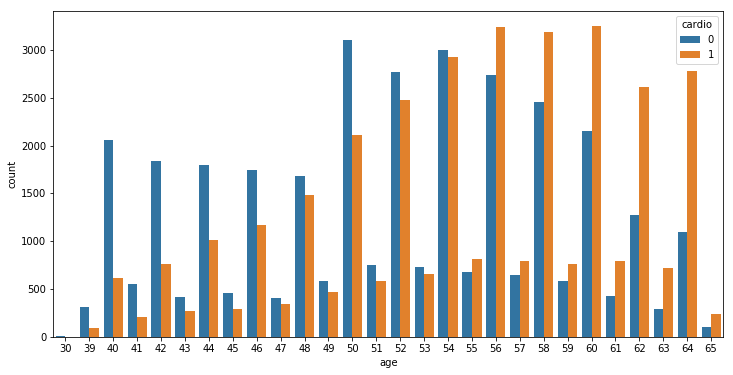

In [8]:
# Lets check age and cardio disease relationship
plt.figure(figsize=(12,6))
sns.countplot(x='age',hue='cardio', data=df)
plt.show()

We can see that, age group from 56 to 65 are more prone to cardio vascular diseases

In [9]:
# Lets check gender count
df["gender"].value_counts()

1    45079
2    24222
Name: gender, dtype: int64

In [10]:
df.groupby('gender')['height'].mean()
# As there is no gender type description, we can assume that based on maximum heights, 2 stands for male and 1 for female

gender
1    161.358659
2    169.952068
Name: height, dtype: float64

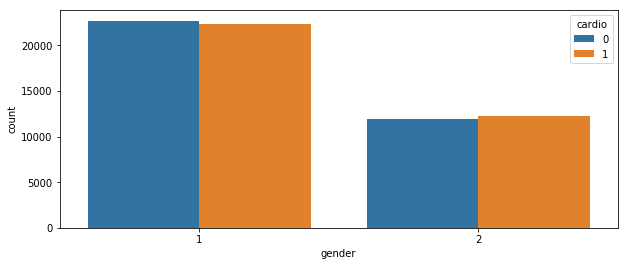

In [11]:
plt.figure(figsize=(10,4))
sns.countplot(x='gender',hue='cardio',data=df)
plt.show()

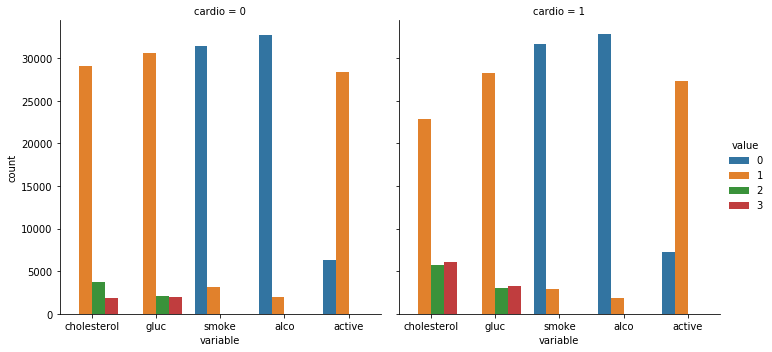

In [12]:
# Lets split categorical variables by target class
df_long = pd.melt(df, id_vars=['cardio'], value_vars=['cholesterol','gluc', 'smoke', 'alco', 'active'])
sns.catplot(x="variable", hue="value", col="cardio",
                data=df_long, kind="count");

It can be noted that people having higher cholesterol and glucose are prone to Cardio diseases

In [13]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,62,1,155,69.0,130,80,2,2,0,0,1,0
1,989,40,1,163,71.0,110,70,1,1,0,0,1,1
2,990,60,1,165,70.0,120,80,1,1,0,0,1,0
3,991,40,2,165,85.0,120,80,1,1,1,1,1,0
4,992,64,1,155,62.0,120,80,1,1,0,0,1,0


In [14]:
# We can remove id which is unique 
df.drop(['id'] ,inplace=True,axis=1)

In [15]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,62,1,155,69.0,130,80,2,2,0,0,1,0
1,40,1,163,71.0,110,70,1,1,0,0,1,1
2,60,1,165,70.0,120,80,1,1,0,0,1,0
3,40,2,165,85.0,120,80,1,1,1,1,1,0
4,64,1,155,62.0,120,80,1,1,0,0,1,0


In [16]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000
mean,53.338177,1.349519,164.362217,74.203027,128.829584,96.650092,1.366806,1.226447,0.088051,0.053881,0.803986,0.499589
std,6.765427,0.476821,8.205337,14.383469,154.775805,189.096240,0.680270,0.572246,0.283371,0.225784,0.396982,0.500003
min,30.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,65.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


We can see outliers in height, weight, ap_hi,ap_lo. -ve values are present in blood pressure.

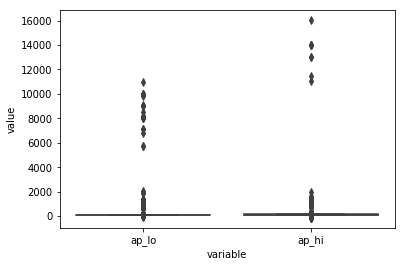

In [17]:
blood_pressure = df.loc[:,['ap_lo','ap_hi']]
sns.boxplot(x = 'variable',y = 'value',data = blood_pressure.melt())

In [18]:
# Let's remove weights and heights, that fall below 2.5% or above 97.5% of a given range.
df.drop(df[(df['height'] > df['height'].quantile(0.975)) | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)

df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)

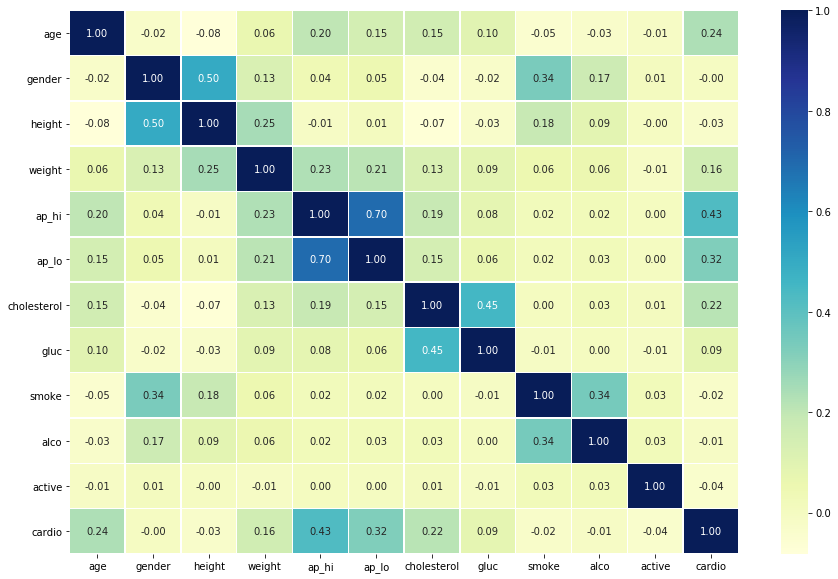

In [19]:
# Let's plot the correlation matrix
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");

We can see that age,ap_hi,ap_lo and cholesterol have +ve impact on cardio

In [20]:
# Lets start modelling
# Split data into X and y
X = df.drop("cardio", axis=1)
y = df["cardio"]

In [21]:
X.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,62,1,155,69.0,130,80,2,2,0,0,1
1,40,1,163,71.0,110,70,1,1,0,0,1
2,60,1,165,70.0,120,80,1,1,0,0,1
3,40,2,165,85.0,120,80,1,1,1,1,1
4,64,1,155,62.0,120,80,1,1,0,0,1


In [22]:
y.head()

0    0
1    1
2    0
3    0
4    0
Name: cardio, dtype: int64

In [24]:
# Split data into train and test sets
np.random.seed(42)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2)

In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((47644, 11), (11911, 11), (47644,), (11911,))

We're going to try 3 different machine learning models:

* Logistic Regression
* K-Nearest Neighbours Classifier
* Random Forest Classifier

In [26]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier()}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    # Set random seed
    # np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [27]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

{'Logistic Regression': 0.7081689194861892,
 'KNN': 0.676685416841575,
 'Random Forest': 0.6994374947527495}

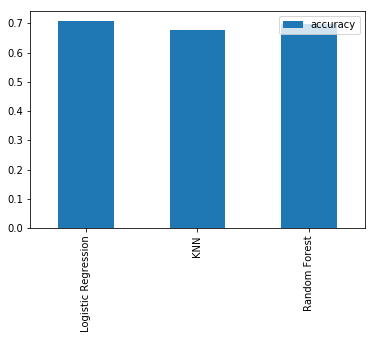

In [28]:
# Compare models
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

In [29]:
def max_acc_score(reg, x, y):
    max_acc_score=0
    for r_state in range(42,101):
        X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = r_state, test_size=0.20)
        reg.fit(X_train, y_train)
        pred = reg.predict(X_test)
        acc_score=accuracy_score(y_test, pred)
        if acc_score > max_acc_score:
            max_acc_score = acc_score
            final_r_state = r_state
    print("The max accuracy score for", reg, "is: ", max_acc_score, " achieved at Random state", final_r_state)

In [30]:
logistic_regression = LogisticRegression()
max_acc_score(logistic_regression, X, y)

The max accuracy score for LogisticRegression() is:  0.7188313323818319  achieved at Random state 80


In [31]:
knn = KNeighborsClassifier()
max_acc_score(knn, X, y)

The max accuracy score for KNeighborsClassifier() is:  0.6915456300898329  achieved at Random state 73


In [32]:
random_forest = RandomForestClassifier()
max_acc_score(random_forest, X, y)

The max accuracy score for RandomForestClassifier() is:  0.7034673830912602  achieved at Random state 95


In [33]:
# Let's tune KNN

train_scores = []
test_scores = []

# Create a list of differnt values for n_neighbors
neighbors = range(1, 21)

# Setup KNN instance
knn = KNeighborsClassifier()

# Loop through different n_neighbors
for i in neighbors:
    knn.set_params(n_neighbors=i)
    
    # Fit the algorithm
    knn.fit(X_train, y_train)
    
    # Update the training scores list
    train_scores.append(knn.score(X_train, y_train))
    
    # Update the test scores list
    test_scores.append(knn.score(X_test, y_test))

Maximum KNN score on the test data: 70.64%


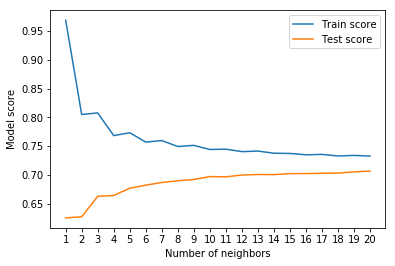

In [34]:
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label="Test score")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")

### Hyperparameter tuning with RandomizedSearchCV
We're going to tune:

* LogisticRegression()
* RandomForestClassifier()

In [36]:
# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [37]:
# Tune LogisticRegression

#np.random.seed(42)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                random_state=80,
                                verbose=True)

# Fit random hyperparameter search model for LogisticRegression
rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   38.0s finished


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   random_state=80, verbose=True)

In [38]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.615848211066026}

In [39]:
rs_log_reg.score(X_test, y_test)

0.7210141885651918

In [40]:
# Tune RandomForestClassifier
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(), 
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           random_state=95,
                           verbose=True)

# Fit random hyperparameter search model for RandomForestClassifier()
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 17.5min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   random_state=95, verbose=True)

In [41]:
# Evaluate the randomized search RandomForestClassifier model
rs_rf.score(X_test, y_test)

0.7268911090588531

Here Randomforest is giving better accuracy.
Evaluting our tuned machine learning classifier, beyond accuracy
* ROC curve and AUC score
* Confusion matrix
* Classification report
* Precision
* Recall
* F1-score
* cross-validation 


In [42]:
# Make predictions with tuned model
y_preds = rs_rf.predict(X_test)

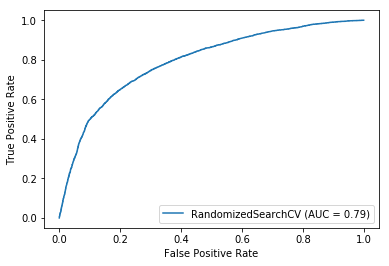

In [43]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(rs_rf, X_test, y_test)

In [44]:
# Confusion matrix
print(confusion_matrix(y_test, y_preds))

[[4769 1323]
 [1930 3889]]


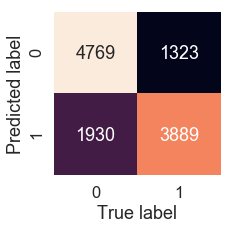

In [45]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False,
                    fmt='g')
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    
plot_conf_mat(y_test, y_preds)

In [46]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.71      0.78      0.75      6092
           1       0.75      0.67      0.71      5819

    accuracy                           0.73     11911
   macro avg       0.73      0.73      0.73     11911
weighted avg       0.73      0.73      0.73     11911



#### Calculate evaluation metrics using cross-validation
We're going to calculate accuracy, precision, recall and f1-score of our model using cross-validation and to do so we'll be using cross_val_score().

In [47]:
# Check best hyperparameters
rs_rf.best_params_

{'n_estimators': 710,
 'min_samples_split': 18,
 'min_samples_leaf': 19,
 'max_depth': None}

In [49]:
# Create a new classifier with best parameters
clf = RandomForestClassifier(n_estimators= 710,
                             min_samples_split= 18,
                             min_samples_leaf=19,
                             max_depth=None)

In [50]:
# Cross-validated accuracy
cv_acc = cross_val_score(clf,
                         X,
                         y,
                         cv=5,
                         scoring="accuracy")
cv_acc

array([0.72579968, 0.73595836, 0.72454034, 0.72907397, 0.7267232 ])

In [51]:
cv_acc = np.mean(cv_acc)
cv_acc

0.728419108387205

In [52]:
# Cross-validated precision
cv_precision = cross_val_score(clf,
                         X,
                         y,
                         cv=5,
                         scoring="precision")
cv_precision=np.mean(cv_precision)
cv_precision

0.7463970105061304

In [53]:
# Cross-validated recall
cv_recall = cross_val_score(clf,
                         X,
                         y,
                         cv=5,
                         scoring="recall")
cv_recall = np.mean(cv_recall)
cv_recall

0.6710132461723723

In [54]:
# Cross-validated f1-score
cv_f1 = cross_val_score(clf,
                         X,
                         y,
                         cv=5,
                         scoring="f1")
cv_f1 = np.mean(cv_f1)
cv_f1

0.7070039220220419

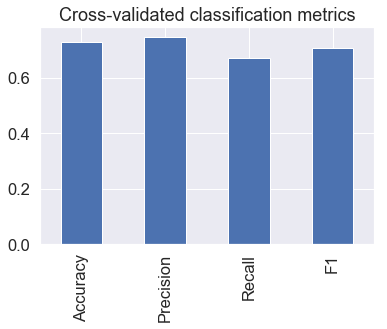

In [55]:
# Visualize cross-validated metrics
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                           "Precision": cv_precision,
                           "Recall": cv_recall,
                           "F1": cv_f1},
                          index=[0])

cv_metrics.T.plot.bar(title="Cross-validated classification metrics",
                      legend=False);

In [57]:
# Lets Save the model as pickle in a file
import pickle
filename = 'cardio_disease_model.pkl'
pickle.dump(rs_rf, open(filename, 'wb'))